In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
embeddings_df = pd.read_csv("./embeddings.csv")
metadata_df = pd.read_csv("./chains_evaluation.csv")

In [3]:
embeddings_df

,sequence_id,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,5SSZ:A,0.041698,0.082317,0.017337,-0.011511,-0.035085,0.112324,-0.028229,-0.023020,-0.021959,...,-0.006125,-0.015080,-0.028736,-0.015365,0.071466,0.034531,-0.021253,-0.044281,-0.019104,0.006675
1,7FY1:A,0.047498,0.025369,0.009100,-0.032689,0.043294,-0.014423,-0.024067,-0.161998,0.039027,...,-0.047904,0.030155,-0.008186,-0.003443,0.015064,-0.079059,-0.009469,-0.074569,0.049260,0.021386
2,7G1Q:A,0.070862,0.011154,-0.006863,-0.022787,0.028306,0.004775,-0.007784,-0.156496,0.027262,...,-0.057456,0.012036,0.008975,-0.017833,0.000690,-0.106954,-0.049073,-0.081838,0.044579,0.043472
3,7G1X:A,0.029538,-0.015357,0.009438,-0.020062,0.003761,0.016320,-0.025629,-0.113614,0.044924,...,-0.047083,0.033137,-0.024161,-0.046833,0.028594,-0.063806,-0.023561,-0.093419,0.046764,0.015743
4,7H9J:A,0.080503,-0.010999,0.064930,0.011473,0.044677,0.068076,-0.060599,-0.020509,-0.018876,...,-0.041747,0.004042,-0.009992,-0.106962,0.006102,0.031285,-0.022343,-0.027299,-0.041440,-0.051504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,9FWC:A,0.016753,0.000013,0.117039,0.009715,0.012918,-0.006572,-0.031365,-0.106783,-0.014808,...,-0.051225,-0.010409,0.063774,-0.085060,0.029770,-0.005850,0.010760,-0.053217,0.001542,-0.072770
1459,9FX5:A,-0.015200,0.094616,0.029028,-0.005583,0.007496,-0.010617,0.052864,-0.057743,0.017855,...,0.008281,-0.000009,-0.013113,-0.004962,0.028970,-0.014288,0.010970,0.069420,0.035354,-0.040685
1460,9G35:A,-0.009528,0.067932,-0.021398,0.032119,-0.025142,-0.010401,-0.075979,-0.037079,0.011097,...,-0.100129,0.018395,-0.007278,-0.024896,0.012935,0.000325,-0.019377,0.029905,-0.043913,-0.001953
1461,9IID:A,0.021642,0.069980,0.014065,-0.065714,-0.132132,0.019948,-0.071130,-0.083702,0.021212,...,-0.034138,-0.029562,-0.044261,-0.111832,0.026946,-0.016103,-0.055561,0.095822,0.022081,0.047651


In [4]:
metadata_df

,pdb_id,label,chain_id,AF_average_pLDDT,OF_average_pLDDT,EF_average_pLDDT,AF_TM_score,OF_TM_score,EF_TM_score,AF_vs_OF_TM_score,...,EF_vs_AF_TM_score,AF_RMSD,OF_RMSD,EF_RMSD,AF_vs_OF_RMSD,OF_vs_EF_RMSD,EF_vs_AF_RMSD,sequence,sequence_length,method_of_acquisition
0,8P0E,monomer,8P0E:A,93.108947,93.535368,89.263158,0.966687,0.967459,0.982825,0.995942,...,0.978701,1.757680,1.738276,0.703625,0.332187,1.373544,1.427521,MADSDIVESYARAAGPVHLRVRDIMDPPPGCKVVVNAANEGLLAGS...,190,X-RAY DIFFRACTION
1,8PX8,monomer,8PX8:A,95.914087,95.609217,95.147826,0.995011,0.995740,0.989534,0.995857,...,0.987997,0.275844,0.253193,0.706370,0.252605,0.671283,0.694650,GSMGKLSEQLKHCNGILKELLSKKHAAYAWPFYKPVDASALGLHDY...,115,X-RAY DIFFRACTION
2,8B2E,monomer,8B2E:A,97.636503,97.136084,94.762238,0.991946,0.979414,0.990990,0.982193,...,0.996032,0.400699,0.668645,0.425292,0.612311,0.497249,0.279309,LVLPGLDALQTRNALAIIAEAKKENVGPHGCQAAITTGLTESSLRI...,143,X-RAY DIFFRACTION
3,8HOE,monomer,8HOE:A,93.577196,79.554392,89.613757,0.988360,0.863854,0.976008,0.873645,...,0.993624,0.564870,2.354328,0.834659,2.298557,2.257695,0.398065,MGSSHHHHHHAFHDVPSLGQKVGAGSQKDVFHSRQDPRQCICLFRP...,189,X-RAY DIFFRACTION
4,8TCE,monomer,8TCE:A,90.252128,89.159681,86.180851,0.938542,0.920785,0.920808,0.948216,...,0.947691,1.805852,2.571247,2.617893,1.681326,0.509903,1.830767,APTENSTGVQDCYRGDGQSYRGTLSTTITGRTCQSWSSMTPHWHRR...,94,X-RAY DIFFRACTION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,8G9J,synthetic,8G9J:A,90.586771,92.542063,89.071749,0.637726,0.984365,0.984592,0.625623,...,0.623380,6.550639,0.678841,0.674661,6.686531,0.287093,6.716066,HHHHHHSGSGENLYFQGSGSEEIVEEAETALKALLEEAEKGGKEDA...,223,X-RAY DIFFRACTION
1459,8OYV,synthetic,8OYV:A,86.604205,88.043795,82.605128,0.981296,0.979309,0.980517,0.992664,...,0.989139,0.725727,0.761958,0.734274,0.453600,0.643009,0.556589,MNEEKREELLEEAKRLLEESLKLLKQAYNTPIEIDLPISGGVKAIL...,195,X-RAY DIFFRACTION
1460,8TNO,synthetic,8TNO:A,90.392837,90.149504,87.758865,0.966437,0.966444,0.958189,0.986057,...,0.968848,1.621622,1.482032,1.525321,0.932028,1.400783,1.206631,MGSVEEVKRIMDLARQKISDAMDELNMDATLKQSVDESMKRAEQRA...,282,X-RAY DIFFRACTION
1461,8FJE,synthetic,8FJE:A,93.426345,93.104138,88.586207,0.970529,0.965841,0.972681,0.995234,...,0.993875,0.845441,0.909988,0.804459,0.302041,0.403145,0.341156,SGSPTPLETLPLEELERRALKIYLRRHGSVPEEEIETMPLEELERK...,145,X-RAY DIFFRACTION


In [5]:
metadata_df.method_of_acquisition.value_counts()

method_of_acquisition
X-RAY DIFFRACTION           1184
ELECTRON MICROSCOPY          144
SOLUTION NMR                 127
SOLID-STATE NMR                4
NEUTRON DIFFRACTION            2
ELECTRON CRYSTALLOGRAPHY       2
Name: count, dtype: int64

## Merge data

In [6]:
X_embeddings = embeddings_df.drop('sequence_id', axis=1)

#metadata_df = metadata_df.copy()
metadata_df['chain_id'] = metadata_df['chain_id'].astype(str)
embeddings_df['chain_id'] = embeddings_df['sequence_id'].astype(str)

metadata_df["xray"] = metadata_df["method_of_acquisition"] == "X-RAY DIFFRACTION"
metadata_df["EF_minus_AF_TM_score"] = metadata_df["EF_TM_score"] - metadata_df["AF_TM_score"]

merged_data = pd.merge(
            metadata_df,
            embeddings_df, 
            left_on='chain_id',
            right_on='chain_id',
            how='inner'
        )

merged_data

,pdb_id,label,chain_id,AF_average_pLDDT,OF_average_pLDDT,EF_average_pLDDT,AF_TM_score,OF_TM_score,EF_TM_score,AF_vs_OF_TM_score,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,8P0E,monomer,8P0E:A,93.108947,93.535368,89.263158,0.966687,0.967459,0.982825,0.995942,...,-0.018924,-0.055101,-0.010038,-0.079929,-0.040604,0.023142,-0.028256,0.006632,0.010835,-0.043973
1,8PX8,monomer,8PX8:A,95.914087,95.609217,95.147826,0.995011,0.995740,0.989534,0.995857,...,-0.003862,-0.036268,-0.056777,-0.021434,0.075105,0.007325,0.011608,-0.015764,-0.016603,0.018275
2,8B2E,monomer,8B2E:A,97.636503,97.136084,94.762238,0.991946,0.979414,0.990990,0.982193,...,-0.120371,-0.012060,-0.037939,-0.037256,-0.024697,0.034764,-0.069274,-0.034956,-0.067968,-0.019934
3,8HOE,monomer,8HOE:A,93.577196,79.554392,89.613757,0.988360,0.863854,0.976008,0.873645,...,0.004794,-0.005468,-0.011793,-0.045643,-0.003415,0.048465,-0.037667,-0.041685,0.048311,0.030363
4,8TCE,monomer,8TCE:A,90.252128,89.159681,86.180851,0.938542,0.920785,0.920808,0.948216,...,-0.045217,-0.015651,-0.013003,-0.089254,0.042249,0.031570,0.010612,-0.017051,0.041658,-0.012780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,8G9J,synthetic,8G9J:A,90.586771,92.542063,89.071749,0.637726,0.984365,0.984592,0.625623,...,-0.098112,0.114060,0.092363,-0.111112,-0.112436,0.047038,-0.000830,-0.036431,0.046928,0.026370
1459,8OYV,synthetic,8OYV:A,86.604205,88.043795,82.605128,0.981296,0.979309,0.980517,0.992664,...,-0.045095,0.218035,0.082360,-0.071727,0.033196,-0.031118,-0.008822,0.015488,0.019231,-0.032048
1460,8TNO,synthetic,8TNO:A,90.392837,90.149504,87.758865,0.966437,0.966444,0.958189,0.986057,...,0.001655,-0.053243,0.000991,-0.050635,-0.062184,0.015350,-0.003545,0.025028,-0.022152,-0.063211
1461,8FJE,synthetic,8FJE:A,93.426345,93.104138,88.586207,0.970529,0.965841,0.972681,0.995234,...,-0.045988,0.127117,0.057083,-0.137953,0.075811,0.125753,-0.053419,-0.075770,-0.004380,0.033179


In [7]:
merged_data.columns[:30]

Index(['pdb_id', 'label', 'chain_id', 'AF_average_pLDDT', 'OF_average_pLDDT',
       'EF_average_pLDDT', 'AF_TM_score', 'OF_TM_score', 'EF_TM_score',
       'AF_vs_OF_TM_score', 'OF_vs_EF_TM_score', 'EF_vs_AF_TM_score',
       'AF_RMSD', 'OF_RMSD', 'EF_RMSD', 'AF_vs_OF_RMSD', 'OF_vs_EF_RMSD',
       'EF_vs_AF_RMSD', 'sequence', 'sequence_length', 'method_of_acquisition',
       'xray', 'EF_minus_AF_TM_score', 'sequence_id', '0', '1', '2', '3', '4',
       '5'],
      dtype='object')

In [8]:
additional_features = ["sequence_length", "xray", "EF_average_pLDDT"] # "AF_average_pLDDT"
target_variable = "EF_minus_AF_TM_score"

category1 = pd.get_dummies(merged_data['label'], prefix='label', dtype=int)

merged_data = pd.concat([merged_data, category1], axis=1)

X = merged_data[X_embeddings.columns.tolist() + category1.columns.tolist() + additional_features]
y = merged_data[target_variable]

X

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,label_complex,label_monomer,label_synthetic,sequence_length,xray,EF_average_pLDDT
0,0.074701,-0.031634,0.010414,-0.010877,-0.031846,0.053747,-0.032714,-0.046688,-0.061814,-0.001304,...,-0.028256,0.006632,0.010835,-0.043973,0,1,0,190,True,89.263158
1,0.074191,0.045541,-0.006785,-0.029171,-0.012676,0.016806,-0.043396,-0.060700,-0.024839,0.008174,...,0.011608,-0.015764,-0.016603,0.018275,0,1,0,115,True,95.147826
2,0.060690,-0.028485,0.020705,-0.057476,-0.053076,-0.009133,-0.034624,-0.027073,-0.031988,-0.059633,...,-0.069274,-0.034956,-0.067968,-0.019934,0,1,0,143,True,94.762238
3,-0.028040,-0.033594,-0.044930,0.010464,-0.069993,-0.040113,-0.053979,-0.072420,0.007218,-0.006695,...,-0.037667,-0.041685,0.048311,0.030363,0,1,0,189,True,89.613757
4,0.034272,0.141000,0.034812,-0.102808,-0.045333,0.007360,0.026951,-0.143174,-0.016837,-0.074851,...,0.010612,-0.017051,0.041658,-0.012780,0,1,0,94,True,86.180851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,0.121245,0.100528,0.090678,-0.184978,0.016666,-0.183547,-0.051702,-0.189545,-0.041149,0.116309,...,-0.000830,-0.036431,0.046928,0.026370,0,0,1,223,True,89.071749
1459,0.035015,-0.040276,0.084468,-0.068787,0.002935,-0.129411,-0.005936,-0.083939,0.165884,0.089207,...,-0.008822,0.015488,0.019231,-0.032048,0,0,1,195,True,82.605128
1460,0.044024,0.000223,0.085759,-0.043875,0.020273,-0.011902,-0.077834,-0.057456,0.018621,0.023004,...,-0.003545,0.025028,-0.022152,-0.063211,0,0,1,282,True,87.758865
1461,0.060813,0.127557,0.079519,-0.160550,0.047703,-0.103272,0.024130,-0.188346,-0.054896,0.114020,...,-0.053419,-0.075770,-0.004380,0.033179,0,0,1,145,True,88.586207


## LightGBM training

In [9]:
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state
    )

In [10]:
X

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,label_complex,label_monomer,label_synthetic,sequence_length,xray,EF_average_pLDDT
0,0.074701,-0.031634,0.010414,-0.010877,-0.031846,0.053747,-0.032714,-0.046688,-0.061814,-0.001304,...,-0.028256,0.006632,0.010835,-0.043973,0,1,0,190,True,89.263158
1,0.074191,0.045541,-0.006785,-0.029171,-0.012676,0.016806,-0.043396,-0.060700,-0.024839,0.008174,...,0.011608,-0.015764,-0.016603,0.018275,0,1,0,115,True,95.147826
2,0.060690,-0.028485,0.020705,-0.057476,-0.053076,-0.009133,-0.034624,-0.027073,-0.031988,-0.059633,...,-0.069274,-0.034956,-0.067968,-0.019934,0,1,0,143,True,94.762238
3,-0.028040,-0.033594,-0.044930,0.010464,-0.069993,-0.040113,-0.053979,-0.072420,0.007218,-0.006695,...,-0.037667,-0.041685,0.048311,0.030363,0,1,0,189,True,89.613757
4,0.034272,0.141000,0.034812,-0.102808,-0.045333,0.007360,0.026951,-0.143174,-0.016837,-0.074851,...,0.010612,-0.017051,0.041658,-0.012780,0,1,0,94,True,86.180851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,0.121245,0.100528,0.090678,-0.184978,0.016666,-0.183547,-0.051702,-0.189545,-0.041149,0.116309,...,-0.000830,-0.036431,0.046928,0.026370,0,0,1,223,True,89.071749
1459,0.035015,-0.040276,0.084468,-0.068787,0.002935,-0.129411,-0.005936,-0.083939,0.165884,0.089207,...,-0.008822,0.015488,0.019231,-0.032048,0,0,1,195,True,82.605128
1460,0.044024,0.000223,0.085759,-0.043875,0.020273,-0.011902,-0.077834,-0.057456,0.018621,0.023004,...,-0.003545,0.025028,-0.022152,-0.063211,0,0,1,282,True,87.758865
1461,0.060813,0.127557,0.079519,-0.160550,0.047703,-0.103272,0.024130,-0.188346,-0.054896,0.114020,...,-0.053419,-0.075770,-0.004380,0.033179,0,0,1,145,True,88.586207


In [11]:
model = LGBMRegressor(
        n_estimators=100,
        random_state=random_state,
        n_jobs=-1
    )

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261626
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 1030
[LightGBM] [Info] Start training from score -0.046400


LGBMRegressor(n_jobs=-1, random_state=42)

In [12]:
y_pred = model.predict(X_test)

In [13]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(np.float64(0.00555684222581692), 0.7388259359410871)

## SHAP Explainer

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

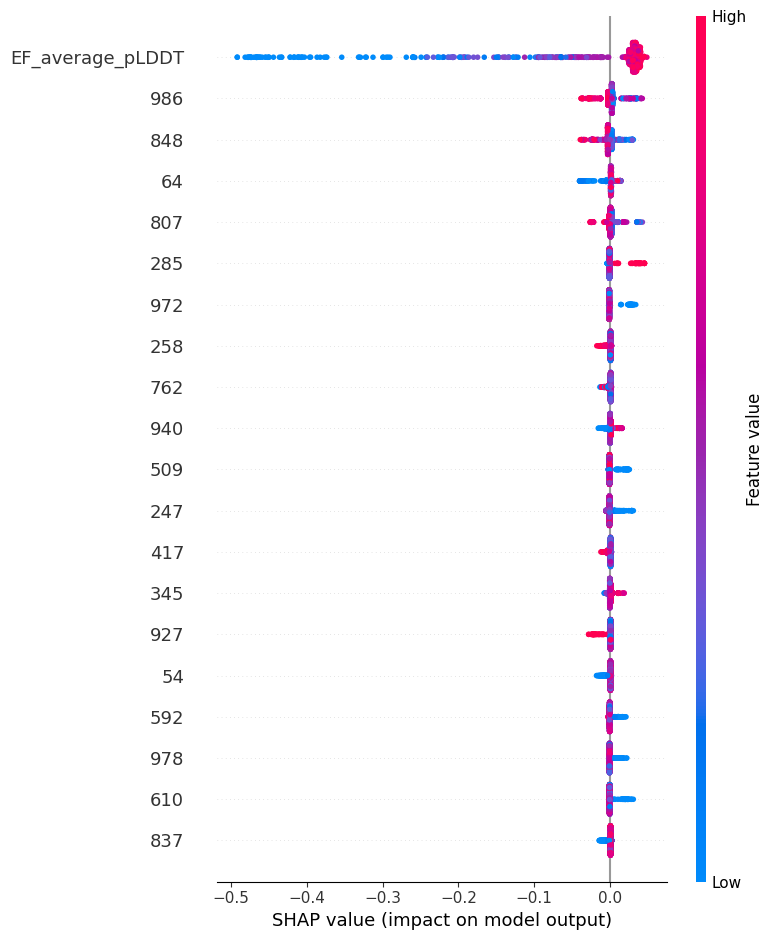

In [15]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, feature_names=X.columns, show=False)
plt.tight_layout()

In [16]:
feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(shap_values).mean(0)
    })
feature_importance = feature_importance.sort_values('importance', ascending=False)

feature_importance.head()

,feature,importance
1029,EF_average_pLDDT,0.057356
986,986,0.004813
848,848,0.004034
64,64,0.002945
807,807,0.002855


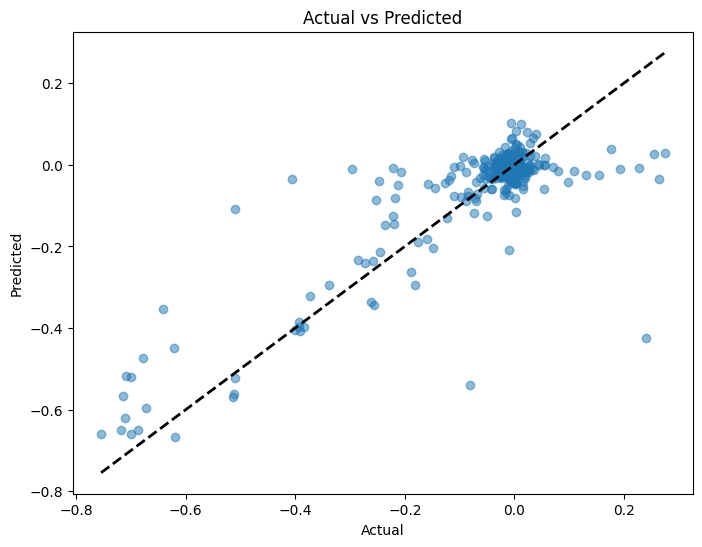

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.savefig('predictions.png')

In [19]:
y.min(), y.max(), y.mean(), y.std()

(np.float64(-0.7547903082886976),
 np.float64(0.41938159879269366),
 np.float64(-0.046761415500238074),
 np.float64(0.1407055943421939))